# Job Posting Volume Forecasting using LSTM

Forecast daily job postings using real data from Kaggle (Indeed USA) and LSTM deep learning.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

###Load and Prepare Data

In [ ]:
df = pd.read_csv('/content/data_science_jobs_indeed_usa.csv')

In [ ]:
df.sample(10)

,Unnamed: 0,Title,Company,Location,Rating,Date,Salary,Description,Links,Descriptions
205,205,Data Engineer II,Nexintech Inc.,"Playa Vista, CA 90094",NaN,PostedPosted 3 days ago,$60 - $72 an hour,Data ETL processes: 3 years (Required).\nColla...,https://www.indeed.com/company/Nexintech-Inc./...,Summary:\nThe main function of the Data Engine...
18,18,Director of CRM & Data Analytics,Ambassador Theatre Group,"New York, NY 10036 (Hell's Kitchen area)",3.7,PostedPosted 13 days ago,"$130,000 - $140,000 a year","Collaborate with central team data science, in...",https://www.indeed.com/rc/clk?jk=2c74a47ca7c1b...,POSITION: Director of CRM & Data Analytics\nLO...
624,624,Data Scientist (Fintech Company),Softdev Integrations,"Las Vegas, NV 89101 (Downtown area)",NaN,PostedPosted 21 days ago,"$50,000 - $75,000 a year",Present information using data visualization t...,https://www.indeed.com/company/Softdev-Integra...,We are looking for a Data Scientist to analyze...
116,116,Data Engineer,CGATE Corporation,Remote,NaN,PostedPosted 18 days ago,$60 - $65 an hour,Experience performing data analysis and data e...,https://www.indeed.com/company/CGATE/jobs/Data...,Location: 100% Remote\nDuration: Long Term\nVi...
953,953,ETL Data Engineer,Gridiron IT,Remote,4.0,EmployerActive 4 days ago,"$150,000 - $170,000 a year",Experience with automated data integration and...,https://www.indeed.com/company/Gridiron-IT/job...,Gridiron IT is seeking a CCTE Data Engineer to...
1176,1176,"Software Engineer, Machine Learning Foundation",Pinterest,+2 locationsRemote,4.2,PostedPosted 30+ days ago,"$155,300 - $232,900 a year","Work with internal customers, ML engineers, an...",https://www.indeed.com/rc/clk?jk=8bdd2924002ce...,About Pinterest:\nMillions of people across th...
1151,1151,Azure Data Engineer,Agiles Enterprise,Remote,NaN,EmployerActive 9 days ago,"$84,107 - $190,641 a year",Candidates should be really strong in Python a...,https://www.indeed.com/company/Prescient/jobs/...,"Databricks (s.Python, sql)\nCandidates should ..."
778,778,Azure Data Engineer,iQuasar LLC,+1 locationRemote,NaN,PostedPosted 2 days ago,$55 - $90 an hour,Extensive hands-on experience implementing dat...,https://www.indeed.com/company/iQuasar-LLC/job...,Job responsibilities include:\nCreate cloud da...
1019,1019,Data Engineer,Unbound,"San Jose, CA",4.3,PostedPosted 5 days ago,"$150,000 - $180,000 a year","Design and build modern data pipelines, data s...",https://www.indeed.com/company/Unbound/jobs/Da...,What is expected of you?\nYou design data solu...
981,981,"Senior Product Manager - Analytics, AI, & Data",Intuit,"San Diego, CA 92129 (Torrey Highlands area)+2 ...",4.2,PostedPosted 4 days ago,NaN,"In depth knowledge of data products, data pipe...",https://www.indeed.com/rc/clk?jk=5aa8cd165c570...,Overview\nIntuit is a global technology platfo...


In [ ]:
len(df)

1200

In [ ]:
df['Date'].notnull().value_counts().sum()

np.int64(1200)

In [ ]:
from datetime import timedelta

# Extract the number of days from the "Date" column
def extract_days_ago(text):
    try:
        parts = text.split()
        for i, part in enumerate(parts):
            if part.isdigit() and 'day' in parts[i+1]:
                return int(part)
    except:
        return None
    return None

df['days_ago'] = df['Date'].apply(extract_days_ago)

# Convert to actual posting date
df['date_posted'] = pd.to_datetime('today') - pd.to_timedelta(df['days_ago'], unit='D')

# Group by date and count postings
df = df.groupby('date_posted').size().reset_index(name='job_postings')

# Set date as index and fill missing dates with 0
df = df.set_index('date_posted').asfreq('D').fillna(0)


In [ ]:
df.head()

,job_postings
date_posted,
2025-06-09 06:27:10.720952,7
2025-06-10 06:27:10.720952,5
2025-06-11 06:27:10.720952,2
2025-06-12 06:27:10.720952,5
2025-06-13 06:27:10.720952,10


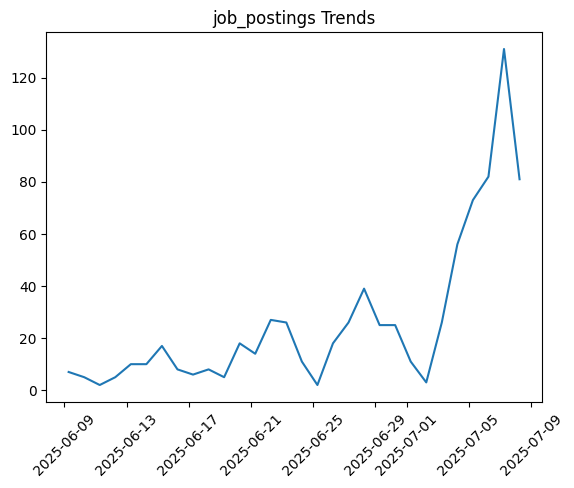

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df)
plt.xticks(rotation=45)
plt.title('job_postings Trends')
plt.show()

### Normalize the Job Postings Time Series

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['job_postings']])

### Create Sequences for LSTM

---



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

sequence_length = 7

X, y = create_sequences(scaled_data, sequence_length)

print("After sequence creation:", type(X), X.shape, type(y), y.shape)

After sequence creation: <class 'numpy.ndarray'> (23, 7, 1) <class 'numpy.ndarray'> (23, 1)


In [ ]:
print("total time steps available:", len(scaled_data))

total time steps available: 30


### Train And Test Split

In [ ]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# Reshape input for LSTM [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
print(type(X_train), X_train.shape)

<class 'numpy.ndarray'> (18, 7, 1)


### Build and Train the LSTM Model

In [ ]:
from sklearn.metrics import mean_squared_error

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=30, batch_size=4)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0148
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0063
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0068
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0057
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0061
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0047
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0058
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0055
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0068
Epoch 13/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0051
Epoch 14/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0048
Epoch 15/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0039
Epoch 16/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 7, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,957 (585.77 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,972 (390.52 KB)

### Evaluate Model and Forecast

In [ ]:
# Calculating RMSE performance metrics
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(actual, predictions))
print(f"RMSE: {rmse:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
RMSE: 64.70


In [ ]:
last_seq = scaled_data[-sequence_length:]
forecast = []
current = last_seq.reshape(1, sequence_length, 1)

for _ in range(30):
    next_val = model.predict(current)[0][0]
    forecast.append(next_val)
    current = np.append(current[:, 1:, :], [[[next_val]]], axis=1)

forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

### Demonstration For Prediction For Next 30 Days

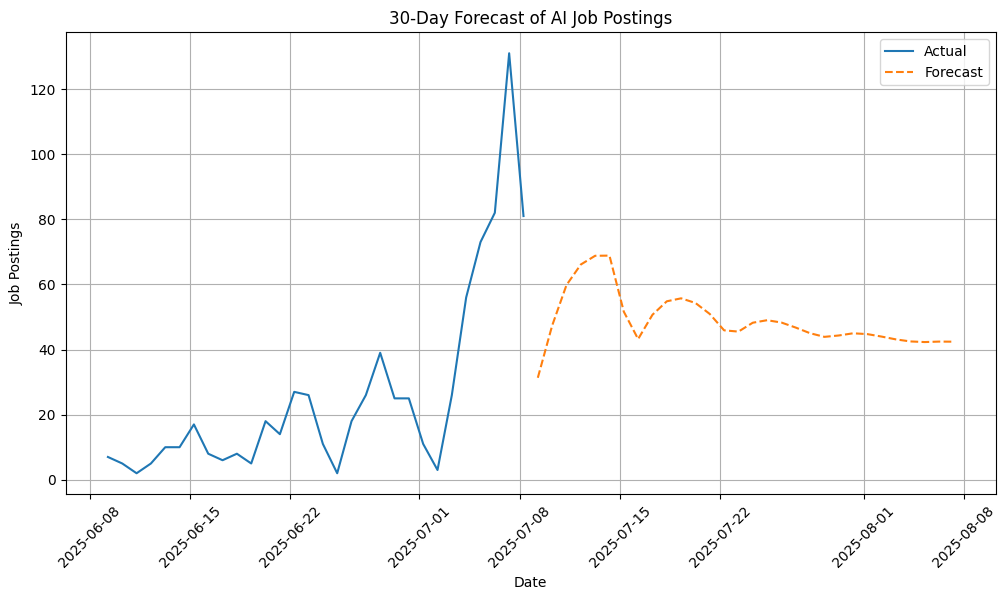

In [ ]:
forecast_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=30)

plt.figure(figsize=(12, 6))
plt.plot(df.index[-60:], df['job_postings'][-60:], label="Actual")
plt.plot(forecast_dates, forecast, label="Forecast", linestyle="--")
plt.title("30-Day Forecast of AI Job Postings")
plt.xlabel("Date")
plt.ylabel("Job Postings")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()
